Second part of laboratories were conducted by <a href="https://github.com/jarek-pawlowski">Jarosław Pawłowski</a>. He created notebooks we used in laboratories. I am really glad that I had him as a tutor.

In second course of ML/AI we were build ML models using pytorch.

In this notebook I will present only some task we had as a homework from notebook.

# Regularization

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.backends import cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import time

import numpy as np

import matplotlib.pyplot as plt
from torch.distributed._spmd.api import Override

plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64
# learning rate is how fast it will descend
model_args['lr'] = .07
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 20
# L2 (ridge) penalty
model_args['L2_lambda'] = 5.e-3
# L1 (LASSO) penalty
model_args['L1_lambda'] = 2.e-4
print(torch.cuda.is_available())

True


### Define problem
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images to train image classifier,
- in order to test various regularizations our vanilla CNN classifier should be overfitted.

### Download the dataset

In [6]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

'rm' is not recognized as an internal or external command,
operable program or batch file.


Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_subset = torch.load('./data/train_subset.pt', map_location=torch.device('cuda:0'))

validation_subset = torch.load('./data/validation_subset.pt', map_location=torch.device('cuda:0'))
test_cifar10 = torch.load('./data/test_cifar10.pth', map_location=torch.device('cuda:0'))
# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_cifar10, range(5000))
for x in train_subset:
    print(x)
    break

(tensor([[[-0.9192, -0.8678, -0.8849,  ..., -1.2445, -0.9705, -0.7137],
         [-0.9534, -0.8849, -0.9020,  ..., -1.2274, -1.0733, -0.5253],
         [-0.9705, -0.8849, -0.8507,  ..., -1.2445, -0.9877,  0.0569],
         ...,
         [-0.1314,  0.0912,  0.4166,  ...,  1.1358,  1.1015,  1.1015],
         [ 0.1254,  0.0227,  0.1426,  ...,  1.1872,  1.1358,  1.1015],
         [-0.0116, -0.1828,  0.0912,  ...,  1.2385,  1.1872,  1.1015]],

        [[-0.7402, -0.7052, -0.7227,  ..., -0.7052, -0.4251, -0.2325],
         [-0.7927, -0.7227, -0.7402,  ..., -0.7577, -0.6001, -0.0749],
         [-0.8102, -0.7227, -0.6877,  ..., -0.8627, -0.6352,  0.3452],
         ...,
         [-0.2325, -0.0049,  0.3277,  ...,  1.1155,  1.0805,  1.0805],
         [ 0.0651, -0.0399,  0.0651,  ...,  1.1681,  1.1155,  1.0805],
         [-0.0399, -0.2325,  0.0476,  ...,  1.2206,  1.1681,  1.0805]],

        [[-0.6890, -0.6367, -0.6541,  ..., -1.0550, -0.8633, -0.4450],
         [-0.7238, -0.6541, -0.6715,  ..., -

In [8]:
# define dataloaders
print(type(train_subset))
# train_subset = torch.utils.data.TensorDataset(train_subset)

train_loader = []
train_data = []
rowx = []
rowy = []
i = 0
for (x, y) in train_subset:
    if i % model_args['batch_size'] == model_args['batch_size']-1:
        train_data.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1
print(1)
print(len(train_data))
print(train_data[0])




validation_loader = []
rowx = []
rowy = []
i = 0
for x, y in validation_subset:
    if i % model_args['batch_size'] == model_args['batch_size'] - 1:
        validation_loader.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1
print(1)
print(len(validation_loader))
print(validation_loader[0])



test_loader = []
rowx = []
rowy = []
i = 0
for x, y in test_subset:
    if i % model_args['batch_size'] == model_args['batch_size'] - 1:
        
        test_loader.append([torch.stack(rowx, dim =0).to("cuda:0"), torch.tensor(rowy, device="cuda:0")])
        rowx = []
        rowy = []
    else:
        rowx.append(x)
        rowy.append(y)
    i += 1
print(1)
print(len(test_loader))
print(test_loader[0])


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

<class 'torch.utils.data.dataset.Subset'>
1
312
[tensor([[[[-0.9192, -0.8678, -0.8849,  ..., -1.2445, -0.9705, -0.7137],
          [-0.9534, -0.8849, -0.9020,  ..., -1.2274, -1.0733, -0.5253],
          [-0.9705, -0.8849, -0.8507,  ..., -1.2445, -0.9877,  0.0569],
          ...,
          [-0.1314,  0.0912,  0.4166,  ...,  1.1358,  1.1015,  1.1015],
          [ 0.1254,  0.0227,  0.1426,  ...,  1.1872,  1.1358,  1.1015],
          [-0.0116, -0.1828,  0.0912,  ...,  1.2385,  1.1872,  1.1015]],

         [[-0.7402, -0.7052, -0.7227,  ..., -0.7052, -0.4251, -0.2325],
          [-0.7927, -0.7227, -0.7402,  ..., -0.7577, -0.6001, -0.0749],
          [-0.8102, -0.7227, -0.6877,  ..., -0.8627, -0.6352,  0.3452],
          ...,
          [-0.2325, -0.0049,  0.3277,  ...,  1.1155,  1.0805,  1.0805],
          [ 0.0651, -0.0399,  0.0651,  ...,  1.1681,  1.1155,  1.0805],
          [-0.0399, -0.2325,  0.0476,  ...,  1.2206,  1.1681,  1.0805]],

         [[-0.6890, -0.6367, -0.6541,  ..., -1.0550, 

In [9]:
import inspect
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}


def train_with_regularization(model, device, train_data, optimizer, criterion,
                              epoch_number,
                              L1_lambda,
                              L2_lambda):
    model.train()
    train_loss = torch.tensor(0., device=device)
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_data):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        #print(inspect.getmembers(optimizer, predicate=inspect.ismethod))
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # L2 regularization implemeted by hand
        
        L2_norm = sum((p**2).sum() for p in model.parameters())
        # L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.parameters())
        #
        loss_regularized = loss + L1_norm*L1_lambda + L2_norm*L2_lambda
        
        # backpropagate the loss
        loss_regularized.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss_len = torch.tensor(len(train_data), device=device)
    train_loss /= train_loss_len
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_data, criterion, message=None):
    model.eval()
    test_loss = torch.tensor(0., device=device)
    correct = torch.tensor(0., device=device)
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_data:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # calculate and sum up batch loss
            test_loss += criterion(output, target)
            # get the index of class with the max probability
            prediction = output.argmax(dim=1)
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_data)
    accuracy = correct / len(test_data)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_data)*model_args['batch_size'], 100.*accuracy/model_args['batch_size']))
    return test_loss, accuracy

def run_training(model, device, criterion, optimizer, no_epochs,
                 L1_lambda=0.,
                 L2_lambda=0.):
    train_loss = torch.tensor([0.], device=device)
    validation_loss = torch.tensor([0.], device=device)
    validation_accuracy = torch.tensor([0.], device=device)
    test_accuracy = torch.tensor([0.], device=device)
    for epoch_number in range(1, no_epochs+1):
        train_loss = torch.cat((train_loss, torch.tensor([train_with_regularization(model, device, train_data,
                                optimizer, criterion, epoch_number,
                                L1_lambda, L2_lambda)], device=device)))
        
        val_loss, val_acc = test(model, device, validation_loader,
                                criterion, 'Validation set')
        
        validation_loss = torch.cat((validation_loss, torch.tensor([val_loss], device=device)))
        validation_accuracy = torch.cat((validation_accuracy, torch.tensor([val_acc], device=device)))
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy = torch.cat((test_accuracy, torch.tensor([test_acc], device=device)))
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    train_loss = train_loss[1:]
    validation_loss = validation_loss[1:]
    validation_accuracy = validation_accuracy[1:]
    test_accuracy = test_accuracy[1:]
    best_accuracy = test_accuracy[torch.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Tasks to do:

0. Try to play with L2 and L1 *lambdas* do get highest possible accuracy.
- e.g. what if we increase *L1_lambda* to be the same as *L2_lambda*
1. Repeat the calculations but for the VGG11 model.
2. Compare amplitudes (plot histograms?) of model weights for the L2 and L1 case -- is L1 a strong feature selector?

3. Reimplement pytorch [SGD method](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD) to get L1 regularization (|w| instead of w**2)

Hint: change line
```python
if weight_decay != 0:
    d_p = d_p.add(param, alpha=weight_decay)
```
to
```python
if weight_decay != 0:
    d_p = d_p.add(torch.sign(param), alpha=weight_decay)
```

## 0

C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1
	Train set: Average loss: 2.0660
	Validation set: Average loss: 1.8499, Accuracy: 1527.0/4992 (31%)
Train Epoch: 2
	Train set: Average loss: 1.8060
	Validation set: Average loss: 1.6718, Accuracy: 1848.0/4992 (37%)
Train Epoch: 3
	Train set: Average loss: 1.6889
	Validation set: Average loss: 1.6103, Accuracy: 1963.0/4992 (39%)
Train Epoch: 4
	Train set: Average loss: 1.6203
	Validation set: Average loss: 1.5872, Accuracy: 2022.0/4992 (41%)
Train Epoch: 5
	Train set: Average loss: 1.5776
	Validation set: Average loss: 1.5555, Accuracy: 2061.0/4992 (41%)
Train Epoch: 6
	Train set: Average loss: 1.5470
	Validation set: Average loss: 1.5424, Accuracy: 2118.0/4992 (42%)
Train Epoch: 7
	Train set: Average loss: 1.5221
	Validation set: Average loss: 1.5127, Accuracy: 2164.0/4992 (43%)
Train Epoch: 8
	Train set: Average loss: 1.5039
	Validation set: Average loss: 1.4881, Accuracy: 2211.0/4992 (44%)
Train Epoch: 9
	Train set: Average loss: 1.4856
	Validation set: Average loss: 1

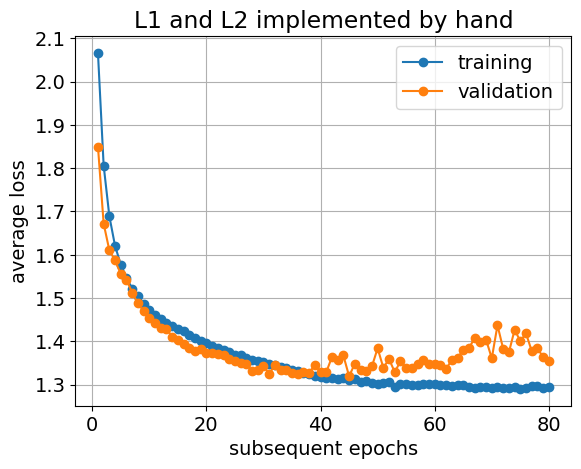

In [10]:
start = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1_l2, val_loss_l1_l2, best_accuracy = run_training(model, device, criterion, optimizer,
                                                         torch.tensor(model_args['epochs']*4, device=device),
                                                         L1_lambda=torch.tensor(0.0005, device=device),
                                                         L2_lambda=torch.tensor(model_args['L2_lambda'], device=device))

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy/model_args["batch_size"]))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_l1_l2.cpu(), val_loss_l1_l2.cpu(), 'L1 and L2 implemented by hand')

## 1

Train Epoch: 1
	Train set: Average loss: 2.3026
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 2
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 3
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 4
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 5
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 6
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 7
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 8
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy: 464.0/4992 (9%)
Train Epoch: 9
	Train set: Average loss: 2.3029
	Validation set: Average loss: 2.3030, Accuracy:

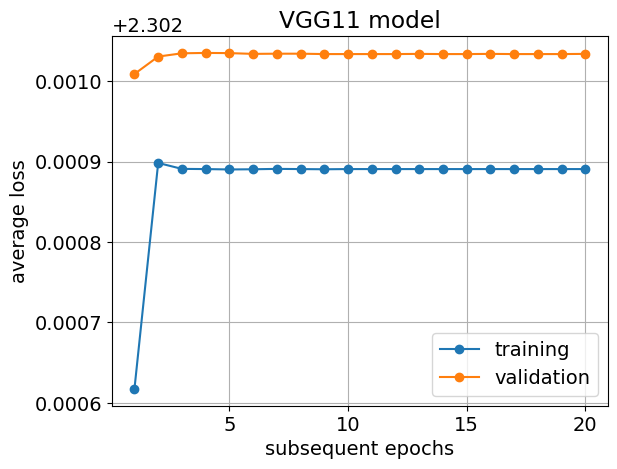

In [11]:
start = time.time()
torch.backends.cudnn.benchmark = True
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_l1 = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_l1.parameters(),
                      lr=model_args['lr'],
                      weight_decay=0.)
no_epochs = torch.tensor(model_args['epochs'], device=device)

train_loss_11, val_loss_11, best_accuracy = run_training(model_l1, device, criterion, optimizer,
                                                         torch.tensor(model_args['epochs'], device=device),
                                                         L1_lambda=torch.tensor(0.0005, device=device),
                                                         L2_lambda=torch.tensor(model_args['L2_lambda'], device=device))

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy/model_args['batch_size']))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_11.cpu(), val_loss_11.cpu(), 'VGG11 model')

# 2.

In [12]:
model_l1.parameters()

<generator object Module.parameters at 0x0000023364044040>

# 3.

Trying to rewrite pytorch model

In [13]:
from torch.optim.optimizer import _group_tensors_by_device_and_dtype
from torch.optim.optimizer import _use_grad_for_differentiable, _default_to_fused_or_foreach
from typing import List, Optional
from torch import Tensor
from overrides import override


class mySDG(optim.SGD):
    def __init__(self, model, lr, weight_decay):
        super().__init__(model, lr=lr, weight_decay=weight_decay)
        
    @_use_grad_for_differentiable
    @override(check_at_runtime=True)
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []

            has_sparse_grad = self._init_group(group, params_with_grad, d_p_list, momentum_buffer_list)

            sgd(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=group['weight_decay'],
                momentum=group['momentum'],
                lr=group['lr'],
                dampening=group['dampening'],
                nesterov=group['nesterov'],
                maximize=group['maximize'],
                has_sparse_grad=has_sparse_grad,
                foreach=group['foreach'],
                fused=group['fused'],
                grad_scale=getattr(self, "grad_scale", None),
                found_inf=getattr(self, "found_inf", None))

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

def sgd(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
        # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
        has_sparse_grad: bool = None,
        foreach: Optional[bool] = None,
        fused: Optional[bool] = None,
        grad_scale: Optional[Tensor] = None,
        found_inf: Optional[Tensor] = None,
        *,
        weight_decay: float,
        momentum: float,
        lr: float,
        dampening: float,
        nesterov: bool,
        maximize: bool):
    r"""Functional API that performs SGD algorithm computation.

    See :class:`~torch.optim.SGD` for details.
    """

    # Respect when the user inputs False/True for foreach or fused. We only want to change
    # the default when neither have been user-specified. Note that we default to foreach
    # and pass False to use_fused. This is not a mistake--we want to give the fused impl
    # bake-in time before making it the default, even if it is typically faster.
    if foreach is None and fused is None:
        # why must we be explicit about an if statement for torch.jit.is_scripting here?
        # because JIT can't handle Optionals nor fancy conditionals when scripting
        if not torch.jit.is_scripting():
            fused, foreach = _default_to_fused_or_foreach(params, differentiable=False, use_fused=False)
        else:
            foreach = False
            fused = False
    if foreach is None:
        foreach = False
    if fused is None:
        fused = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')
    if fused and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with fused optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_sgd
    elif fused and not torch.jit.is_scripting():
        func = _fused_sgd
    else:
        func = _single_tensor_sgd

    func(params,
         d_p_list,
         momentum_buffer_list,
         weight_decay=weight_decay,
         momentum=momentum,
         lr=lr,
         dampening=dampening,
         nesterov=nesterov,
         has_sparse_grad=has_sparse_grad,
         maximize=maximize,
         grad_scale=grad_scale,
         found_inf=found_inf)    
    
def _single_tensor_sgd(params: List[Tensor],
                   d_p_list: List[Tensor],
                   momentum_buffer_list: List[Optional[Tensor]],
                   grad_scale: Optional[Tensor],
                   found_inf: Optional[Tensor],
                   *,
                   weight_decay: float,
                   momentum: float,
                   lr: float,
                   dampening: float,
                   nesterov: bool,
                   maximize: bool,
                   has_sparse_grad: bool):
    assert grad_scale is None and found_inf is None
    for i, param in enumerate(params):
        d_p = d_p_list[i] if not maximize else -d_p_list[i]

        if weight_decay != 0:
            d_p = d_p.add(torch.sign(param), alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        param.add_(d_p, alpha=-lr)

def _multi_tensor_sgd(params: List[Tensor],
                  grads: List[Tensor],
                  momentum_buffer_list: List[Optional[Tensor]],
                  grad_scale: Optional[Tensor],
                  found_inf: Optional[Tensor],
                  *,
                  weight_decay: float,
                  momentum: float,
                  lr: float,
                  dampening: float,
                  nesterov: bool,
                  maximize: bool,
                  has_sparse_grad: bool):
    assert grad_scale is None and found_inf is None
    
    if len(params) == 0:
        return
    grouped_tensors = _group_tensors_by_device_and_dtype([params, grads, momentum_buffer_list], with_indices=True)
    for ((device_params, device_grads, device_momentum_buffer_list), indices) in grouped_tensors.values():
        device_has_sparse_grad = has_sparse_grad and any(grad.is_sparse for grad in device_grads)
        if maximize:
            device_grads = torch._foreach_neg(device_grads)
        paramss = []
        for param in device_grads:
            paramss.append(torch.sign(param))
        if weight_decay != 0:
            # Re-use the intermediate memory (device_grads) already allocated for maximize
            
            if maximize:
                torch._foreach_add_(paramss, device_params, alpha=weight_decay)
            else:
                device_grads = torch._foreach_add(paramss, device_params, alpha=weight_decay)
        if momentum != 0:
            bufs = []

            all_states_with_momentum_buffer = True
            for i in range(len(device_momentum_buffer_list)):
                if device_momentum_buffer_list[i] is None:
                    all_states_with_momentum_buffer = False
                    break
                else:
                    bufs.append(device_momentum_buffer_list[i])

            if all_states_with_momentum_buffer:
                torch._foreach_mul_(bufs, momentum)
                torch._foreach_add_(bufs, device_grads, alpha=1 - dampening)
            else:
                bufs = []
                for i in range(len(device_momentum_buffer_list)):
                    if device_momentum_buffer_list[i] is None:
                        buf = device_momentum_buffer_list[i] = momentum_buffer_list[indices[i]] = \
                            torch.clone(device_grads[i]).detach()
                    else:
                        buf = device_momentum_buffer_list[i]
                        buf.mul_(momentum).add_(device_grads[i], alpha=1 - dampening)

                    bufs.append(buf)

            if nesterov:
                torch._foreach_add_(device_grads, bufs, alpha=momentum)
            else:
                device_grads = bufs

        if not device_has_sparse_grad:
            torch._foreach_add_(device_params, device_grads, alpha=-lr)
        else:
            # foreach APIs don't support sparse
            for i in range(len(device_params)):
                device_params[i].add_(device_grads[i], alpha=-lr)
def _fused_sgd(
    params: List[Tensor],
    grads: List[Tensor],
    momentum_buffer_list: List[Optional[Tensor]],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    weight_decay: float,
    momentum: float,
    lr: float,
    dampening: float,
    nesterov: bool,
    maximize: bool,
    has_sparse_grad: bool,
) -> None:
    if not params:
        return
    if has_sparse_grad:
        raise RuntimeError("`_fused_sgd` does not support sparse gradients")
    grad_scale_dict = {grad_scale.device: grad_scale} if grad_scale is not None else None
    found_inf_dict = {found_inf.device: found_inf} if found_inf is not None else None

    no_momentum_buffer = momentum == 0
    is_first_step = all(t is None for t in momentum_buffer_list) and not no_momentum_buffer
    if is_first_step:
        for i, g in enumerate(grads):
            momentum_buffer_list[i] = torch.empty_like(g)
    grouped_tensors = _group_tensors_by_device_and_dtype(
        [params, grads, momentum_buffer_list], with_indices=False)
    for (device, dtype), ((device_params, device_grads, device_momentum_buffer_list), _) in grouped_tensors.items():
        device_grad_scale, device_found_inf = None, None
        if grad_scale is not None:
            if device not in grad_scale_dict:
                grad_scale_dict[device] = grad_scale.to(device)
            device_grad_scale = grad_scale_dict[device]
        if found_inf is not None:
            if device not in found_inf_dict:
                found_inf_dict[device] = found_inf.to(device)
            device_found_inf = found_inf_dict[device]
        torch._fused_sgd_(
            device_params,
            device_grads,
            [] if no_momentum_buffer else device_momentum_buffer_list,
            weight_decay=weight_decay,
            momentum=momentum,
            lr=lr,
            dampening=dampening,
            nesterov=nesterov,
            maximize=maximize,
            is_first_step=is_first_step,
            grad_scale=device_grad_scale,
            found_inf=device_found_inf,
        )


cuda
Train Epoch: 1
	Train set: Average loss: 1.9918
	Validation set: Average loss: 1.8135, Accuracy: 1611.0/4992 (32%)
Train Epoch: 2
	Train set: Average loss: 1.7377
	Validation set: Average loss: 1.6777, Accuracy: 1899.0/4992 (38%)
Train Epoch: 3
	Train set: Average loss: 1.6354
	Validation set: Average loss: 1.6154, Accuracy: 2017.0/4992 (40%)
Train Epoch: 4
	Train set: Average loss: 1.5691
	Validation set: Average loss: 1.5601, Accuracy: 2105.0/4992 (42%)
Train Epoch: 5
	Train set: Average loss: 1.5170
	Validation set: Average loss: 1.5212, Accuracy: 2199.0/4992 (44%)
Train Epoch: 6
	Train set: Average loss: 1.4764
	Validation set: Average loss: 1.4834, Accuracy: 2264.0/4992 (45%)
Train Epoch: 7
	Train set: Average loss: 1.4415
	Validation set: Average loss: 1.4680, Accuracy: 2281.0/4992 (46%)
Train Epoch: 8
	Train set: Average loss: 1.4102
	Validation set: Average loss: 1.4417, Accuracy: 2338.0/4992 (47%)
Train Epoch: 9
	Train set: Average loss: 1.3822
	Validation set: Average lo

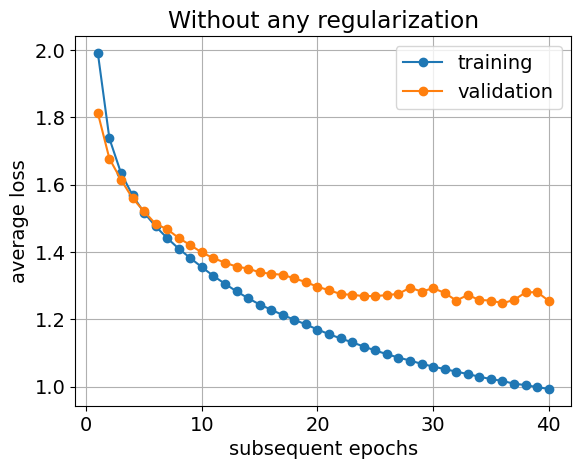

In [14]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
start = time.time()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = mySDG(model.parameters(),
                      lr=model_args['lr']*0.005,
                      weight_decay=0.1)

train_loss_0, val_loss_0, best_accuracy = run_training(model, device, criterion, optimizer, torch.tensor(model_args['epochs']*2, device=device))

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy/model_args['batch_size']))
end = time.time()

print("Time needed: {:.0f}s".format(end - start))
plot_loss(train_loss_0.cpu(), val_loss_0.cpu(), 'Without any regularization')
